# 04 - Conclusion & Interpretation

This notebook bridges the gap between model performance metrics (RMSE, MAE, R²) and real-world operational value (NASA score, risk management).

In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from src.config import (
    DATA_RAW,
    DATA_PROCESSED,
    OUTPUTS_PLOTS,
    OUTPUTS_MODELS,
    CLIP_RUL,
    DATASET,
    THRESHOLD
)
from src.preprocessing import (
    remove_low_variance_features,
    add_features
)

OUTPUTS_PLOTS.mkdir(parents=True, exist_ok=True)

## 1 - NASA Benchmark Predictions

We reload the final model (trained on the full training set) and recompute predictions on the NASA test set.

In [2]:
final_rf_pipeline = joblib.load(OUTPUTS_MODELS / f'final_rf_{DATASET}.joblib')
cols_rf           = joblib.load(OUTPUTS_MODELS / f'cols_rf_{DATASET}.joblib')

test_nasa = pd.read_csv(DATA_RAW / 'test_FD001.txt', sep=r'\s+', header=None)
test_nasa = test_nasa.dropna(axis=1, how='all')
test_nasa.columns = ['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3'] + \
                    [f'sensor_{i}' for i in range(1, 22)]
test_nasa = remove_low_variance_features(test_nasa)
test_nasa = add_features(test_nasa)

last_cycles = test_nasa.groupby('unit_number').last().reset_index()
X_nasa      = last_cycles[cols_rf]

rul_true = pd.read_csv(DATA_RAW / 'RUL_FD001.txt', sep=r'\s+', header=None)
rul_true.columns = ['RUL']
rul_true['RUL']  = rul_true['RUL'].clip(upper=CLIP_RUL)

y_pred = final_rf_pipeline.predict(X_nasa)
y_true = rul_true['RUL'].values

errors = y_pred - y_true

print(f"Number of engines evaluated : {len(y_true)}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred)):.3f}")
print(f"MAE  : {mean_absolute_error(y_true, y_pred):.3f}")
print(f"R²   : {r2_score(y_true, y_pred):.3f}")

Number of engines evaluated : 100
RMSE : 17.336
MAE  : 12.100
R²   : 0.806


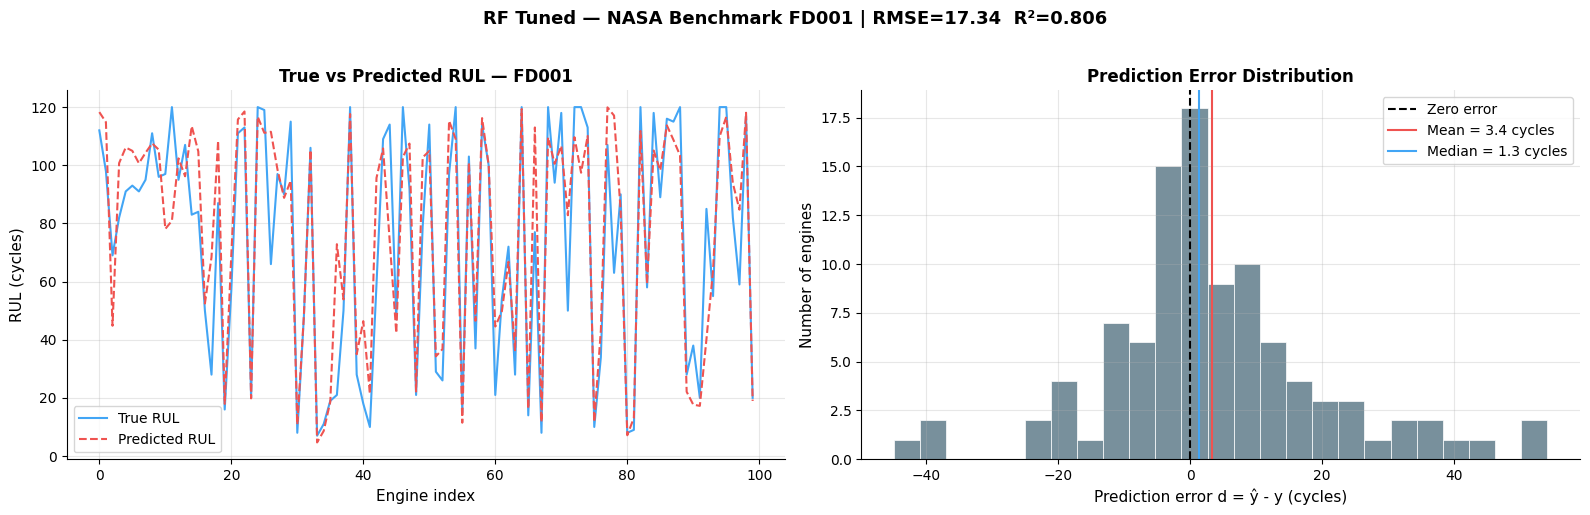

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

ax = axes[0]
x  = np.arange(len(y_true))
ax.plot(x, y_true,  color='#42a5f5', linewidth=1.5, label='True RUL')
ax.plot(x, y_pred,  color='#ef5350', linewidth=1.5, label='Predicted RUL', linestyle='--')
ax.set_xlabel('Engine index', fontsize=11)
ax.set_ylabel('RUL (cycles)', fontsize=11)
ax.set_title(f'True vs Predicted RUL — {DATASET}', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

###

ax = axes[1]
ax.hist(errors, bins=25, color='#78909c', edgecolor='white', linewidth=0.5)
ax.axvline(0,             color='black', linestyle='--', linewidth=1.5, label='Zero error')
ax.axvline(errors.mean(), color='#ef5350', linestyle='-', linewidth=1.5,
           label=f'Mean = {errors.mean():.1f} cycles')
ax.axvline(np.median(errors), color='#42a5f5', linestyle='-', linewidth=1.5,
           label=f'Median = {np.median(errors):.1f} cycles')
ax.set_xlabel('Prediction error d = ŷ - y (cycles)', fontsize=11)
ax.set_ylabel('Number of engines', fontsize=11)
ax.set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.suptitle(f'RF Tuned — NASA Benchmark {DATASET} | RMSE={np.sqrt(mean_squared_error(y_true, y_pred)):.2f}  R²={r2_score(y_true, y_pred):.3f}',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUTS_PLOTS / f'04_true_vs_pred_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

## 2 - NASA Scoring Function

The NASA scoring function was introduced in the 2008 Prognostics and Health Management (PHM) challenge to evaluate RUL predictions in a way that reflects real operational consequences.

For each engine, the individual score is:

$$s_i = \begin{cases} e^{-d_i/13} - 1 & \text{if } d_i < 0 \text{ (early prediction)} \\ e^{d_i/10} - 1 & \text{if } d_i \geq 0 \text{ (late prediction)} \end{cases}$$

where $d_i = \hat{y}_i - y_i$ is the prediction error.

The total score is $S = \sum_i s_i$. Lower is better, an undetected failure is far more costly than a preventive maintenance action.

In [4]:
def nasa_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Compute the NASA scoring function for RUL predictions.

    Parameters
    ----------
    y_true : np.ndarray
        True RUL values.
    y_pred : np.ndarray
        Predicted RUL values.

    Returns
    -------
    float
        NASA score. Lower is better.
    """
    d = y_pred - y_true
    scores = np.where(d < 0, np.exp(-d / 13) - 1, np.exp(d / 10) - 1)
    return float(np.sum(scores))


score = nasa_score(y_true, y_pred)
print(f"NASA Score : {score:.2f}")

NASA Score : 902.75


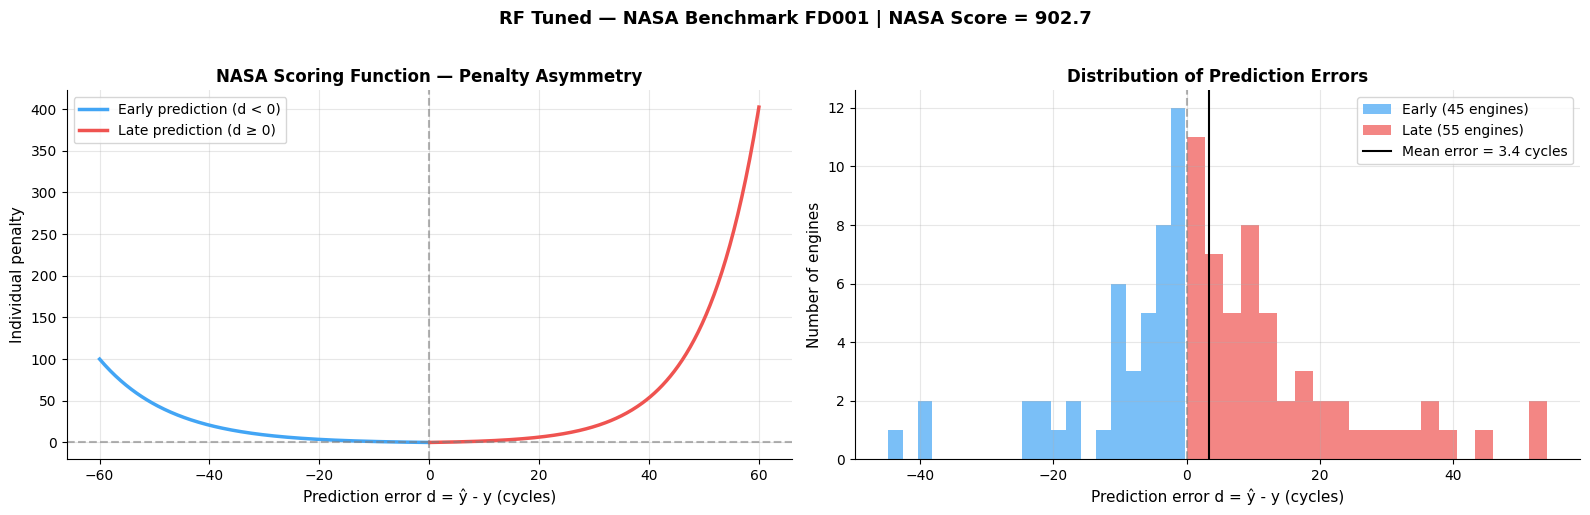

In [5]:
d_range = np.linspace(-60, 60, 500)
penalty = np.where(d_range < 0, np.exp(-d_range / 13) - 1, np.exp(d_range / 10) - 1)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

ax = axes[0]
ax.plot(d_range[d_range < 0], penalty[d_range < 0],
        color='#42a5f5', linewidth=2.5, label='Early prediction (d < 0)')
ax.plot(d_range[d_range >= 0], penalty[d_range >= 0],
        color='#ef5350', linewidth=2.5, label='Late prediction (d ≥ 0)')
ax.axvline(0, color='grey', linestyle='--', alpha=0.6)
ax.axhline(0, color='grey', linestyle='--', alpha=0.6)
ax.set_xlabel('Prediction error d = ŷ - y (cycles)', fontsize=11)
ax.set_ylabel('Individual penalty', fontsize=11)
ax.set_title('NASA Scoring Function — Penalty Asymmetry', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

###

ax = axes[1]
early = errors[errors < 0]
late  = errors[errors >= 0]

ax.hist(early, bins=20, color='#42a5f5', alpha=0.7, label=f'Early ({len(early)} engines)')
ax.hist(late,  bins=20, color='#ef5350', alpha=0.7, label=f'Late ({len(late)} engines)')
ax.axvline(0,            color='grey',   linestyle='--', alpha=0.6)
ax.axvline(errors.mean(), color='black', linestyle='-',  linewidth=1.5,
           label=f'Mean error = {errors.mean():.1f} cycles')
ax.set_xlabel('Prediction error d = ŷ - y (cycles)', fontsize=11)
ax.set_ylabel('Number of engines', fontsize=11)
ax.set_title('Distribution of Prediction Errors', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.suptitle(f'RF Tuned — NASA Benchmark {DATASET} | NASA Score = {score:.1f}',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUTS_PLOTS / f'04_nasa_scoring_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

A NASA score of 902.7 is an encouraging result, ranking our model among the top 6 (based on the PHM 2008 competition results). However, this should be interpreted with caution, as we only used the FD001 dataset, which is the easiest subset.

## 3 - Operational and financial risk management

To translate our model performance into business value, we categorize predictions into three operational zones:

| Zone | Condition | Operational consequence |
|------|-----------|------------------------|
| **Safe** | $ -13 <= d <= 13 $ cycles | Maintenance planned correctly |
| **Early warning** | $d < -13$ cycles | Unnecessary early intervention |
| **Danger** | $d > 13$ cycles | Engine may fail before maintenance, critical safety risk |

The threshold of 13 cycles is derived from the NASA scoring function scale parameter for early predictions.

In [6]:
n_safe  = np.sum(np.abs(errors) <= THRESHOLD)
n_early = np.sum(errors < -THRESHOLD)
n_late  = np.sum(errors > THRESHOLD)
n_total = len(errors)

print(f"Safe predictions  (|d| ≤ {THRESHOLD}) : {n_safe:3d} / {n_total}  ({100*n_safe/n_total:.1f}%)")
print(f"Early predictions (d  < -{THRESHOLD}) : {n_early:3d} / {n_total}  ({100*n_early/n_total:.1f}%)")
print(f"Late predictions  (d  >  {THRESHOLD}) : {n_late:3d} / {n_total}  ({100*n_late/n_total:.1f}%)")
print(f"\nDanger rate : {100*n_late/n_total:.1f}%")

Safe predictions  (|d| ≤ 13) :  71 / 100  (71.0%)
Early predictions (d  < -13) :  10 / 100  (10.0%)
Late predictions  (d  >  13) :  19 / 100  (19.0%)

Danger rate : 19.0%


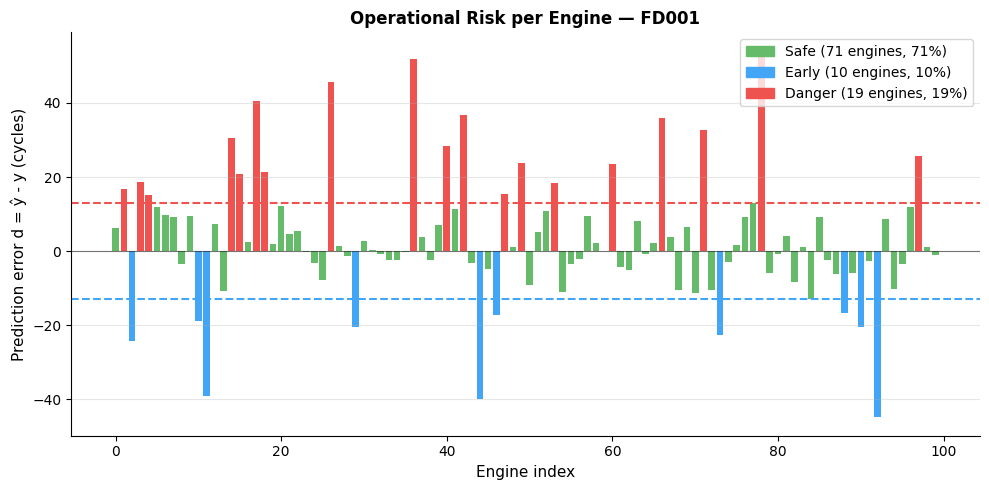

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

colors = np.where(errors > THRESHOLD, '#ef5350',
         np.where(errors < -THRESHOLD, '#42a5f5', '#66bb6a'))

ax.bar(range(n_total), errors, color=colors, edgecolor='none', width=0.8)
ax.axhline( THRESHOLD, color='#ef5350', linestyle='--', linewidth=1.5, label=f'+{THRESHOLD} cycles (danger threshold)')
ax.axhline(-THRESHOLD, color='#42a5f5', linestyle='--', linewidth=1.5, label=f'-{THRESHOLD} cycles (early threshold)')
ax.axhline(0, color='black', linewidth=0.8, alpha=0.5)

safe_patch  = mpatches.Patch(color='#66bb6a', label=f'Safe ({n_safe} engines, {100*n_safe/n_total:.0f}%)')
early_patch = mpatches.Patch(color='#42a5f5', label=f'Early ({n_early} engines, {100*n_early/n_total:.0f}%)')
late_patch  = mpatches.Patch(color='#ef5350', label=f'Danger ({n_late} engines, {100*n_late/n_total:.0f}%)')

ax.legend(handles=[safe_patch, early_patch, late_patch], fontsize=10, loc='upper right')
ax.set_xlabel('Engine index', fontsize=11)
ax.set_ylabel('Prediction error d = ŷ - y (cycles)', fontsize=11)
ax.set_title(f'Operational Risk per Engine — {DATASET}', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUTS_PLOTS / f'04_operational_risk_{DATASET}.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

## 5 - Physical Interpretation

T50 (LPT outlet temperature) emerges as the dominant predictor of RUL. This result aligns with FD001 dataset single fault mode. Because T50 sits at the very end of the gas path, it acts as a natural integrator of all upstream degradation mechanisms, making it the most informative single signal for RUL estimation.

The use of a 5-cycle rolling mean across all selected features is physically motivated: mechanical degradation is a slow, cumulative process whose signature is more reliably captured over several consecutive cycles than in any instantaneous measurement.

## 6 - Conclusion

### Results

Our final Random Forest Tuned model, trained on the full CMAPSS FD001 training set, achieves:
- RMSE = 17.34 cycles on the NASA benchmark test set
- R² = 0.806 -> the model explains 80% of RUL variance on unseen engines
- NASA Score = 902.7, consistent with published results for classical ML approaches on FD001

### Operational/Business perspective

In a real maintenance context, maintenance is triggered when the predicted RUL falls below an operational threshold, determined by a human operator. 
For aerospace applications, the threshold should be set conservatively low given the catastrophic cost of an in-flight failure.

### Limitations and next steps

- FD001 is the simplest CMAPSS subset: single operating condition, single fault mode. Extending to FD002/FD003/FD004 (multiple conditions, multiple fault modes) would better reflect real-world complexity.

- The RUL clipping at 120 cycles is a modeling assumption. In production, a two-stage model could first classify whether the engine is in its degradation phase before predicting RUL.

- LSTM / Transformer architectures are known to outperform classical ML models on this benchmark by explicitly modeling temporal dependencies, this is what I will focus on next.